<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Поиск-дубликатов" data-toc-modified-id="Поиск-дубликатов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Поиск дубликатов</a></span></li><li><span><a href="#Изменение-типа-данных,-структурирование-столбцов-и-обработка-артефактов" data-toc-modified-id="Изменение-типа-данных,-структурирование-столбцов-и-обработка-артефактов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Изменение типа данных, структурирование столбцов и обработка артефактов</a></span></li><li><span><a href="#Формирование-общего-датафрейма" data-toc-modified-id="Формирование-общего-датафрейма-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Формирование общего датафрейма</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Проверка-гипотез" data-toc-modified-id="Проверка-гипотез-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка гипотез</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

# Определение наиболее доходного телеком-тарифа

**Цель исследования** — определить, какой из двух тарифов федерального оператора сотовой связи приносит больше дохода. Полученная информация поможет коммерческому департаменту компании скорректировать рекламный бюджет.

Данные, предоставленные оператором — выборка из 500 клиентов компании за 2018 год. Она содержит, помимо прочего, следующую информацию:
- Имя и фамилию пользователя
- Возраст пользователя
- Город проживания пользователя
- Сведения об используемом тарифе
- Объём звонков, сообщений и интернет-трафика, потраченных пользователем

**Ход исследования**

Откроем полученные файлы с данными и предварительно изучим их.

Проверим данные на пропуски, дубликаты и иные артефакты, исправим обнаруженные проблемы. Далее сформируем общий датафрейм с нужной информацией, после чего проведём анализ данных.

На последних этапах работы проверим сформулированные гипотезы, на основе чего и сформируем итоговый вывод.
 
Таким образом, исследование пройдёт в пять этапов:
 1. Обзор данных.
 2. Подготовка данных.
 3. Анализ данных.
 4. Проверка гипотез.
 5. Итоговый вывод.

## Обзор данных

Изучим общую информацию о предоставленных 5 файлах.

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import math as mt
from scipy import stats as st
import plotly.express as px
import plotly.io as pio

In [2]:
# чтение csv-файлов и создание датафреймов
users = pd.read_csv('data_users.csv')
tariffs = pd.read_csv('data_tariffs.csv')
calls = pd.read_csv('data_calls.csv')
messages = pd.read_csv('data_messages.csv')
internet_traffic = pd.read_csv('data_internet.csv')

pd.options.display.float_format = '{:.2f}'.format
pio.renderers.default='svg'

In [3]:
# получение случайных 10 строк таблиц
display(tariffs)
tables = [users, calls, messages, internet_traffic]
for table in tables:
    display(table.sample(10, random_state=1))

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
304,1304,68,NaN,Владимир,Илья,Соловьёв,2018-11-05,ultra
340,1340,50,NaN,Пенза,Тимофей,Алютин,2018-01-30,smart
47,1047,67,NaN,Саратов,Милица,Меркулова,2018-10-29,smart
67,1067,45,NaN,Москва,Юзефа,Абашкина,2018-04-09,smart
479,1479,40,NaN,Хабаровск,Игорь,Богданов,2018-07-03,smart
485,1485,34,NaN,Киров,Таисия,Сухова,2018-12-29,ultra
310,1310,28,NaN,Уфа,Рудольф,Нестеров,2018-03-22,ultra
31,1031,66,NaN,Москва,Лаврентий,Тимофеев,2018-11-02,smart
249,1249,25,NaN,Курск,Изольда,Авдушева,2018-08-14,smart
90,1090,54,2018-12-03,Череповец,Екатерина,Астафьева,2018-10-11,ultra


,id,call_date,duration,user_id
26953,1066_374,2018-08-26,0.00,1066
66122,1168_1273,2018-03-28,16.05,1168
67325,1171_350,2018-09-14,6.23,1171
74643,1186_465,2018-09-02,0.79,1186
192311,1472_124,2018-05-04,5.94,1472
47375,1118_664,2018-10-24,13.41,1118
91143,1227_563,2018-08-03,15.15,1227
3818,1010_67,2018-08-16,14.29,1010
182822,1454_574,2018-09-23,9.98,1454
187346,1463_0,2018-12-05,10.63,1463


,id,message_date,user_id
45696,1197_26,2018-12-31,1197
66091,1282_523,2018-11-30,1282
18743,1082_184,2018-10-18,1082
33759,1146_557,2018-12-22,1146
11403,1048_49,2018-09-27,1048
97793,1401_125,2018-08-10,1401
406,1000_406,2018-12-29,1000
71393,1302_221,2018-10-23,1302
103004,1420_11,2018-12-12,1420
53795,1238_208,2018-10-08,1238


,Unnamed: 0,id,mb_used,session_date,user_id
35745,35745,1124_125,122.45,2018-12-03,1124
18383,18383,1064_102,320.60,2018-12-19,1064
59774,59774,1203_22,605.96,2018-06-17,1203
56317,56317,1188_123,781.73,2018-05-08,1188
52231,52231,1176_386,150.98,2018-08-20,1176
20276,20276,1068_26,389.65,2018-12-04,1068
82748,82748,1281_64,841.89,2018-11-07,1281
129266,129266,1431_300,461.23,2018-11-26,1431
46783,46783,1160_75,0.00,2018-08-15,1160
48492,48492,1168_260,336.06,2018-07-28,1168


In [4]:
# получение общей информации о данных в таблицах
tables = [tariffs, users, calls, messages, internet_traffic]
for table in tables:
    print(table.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-

In [5]:
# получение данных о характерных значениях таблиц
tables = [users, calls, internet_traffic]
for table in tables:
    display(table.describe().style.format('{:.0f}'))

,user_id,age
count,500,500
mean,1250,47
std,144,17
min,1000,18
25%,1125,32
50%,1250,46
75%,1374,62
max,1499,75


,duration,user_id
count,202607,202607
mean,7,1254
std,6,145
min,0,1000
25%,1,1126
50%,6,1260
75%,11,1379
max,38,1499


,Unnamed: 0,mb_used,user_id
count,149396,149396,149396
mean,74698,370,1252
std,43127,278,144
min,0,0,1000
25%,37349,138,1130
50%,74698,348,1251
75%,112046,560,1380
max,149395,1725,1499


**Промежуточные выводы**

При просмотре таблиц можно было заметить определённые проблемы и артефакты, такие как:

1. Для столбцов с датой выбран типы данных `object` вместо `datetime`.
3. В таблице с данными об интернет трафике присутствует лишний столбец, по всей видимости дублирующий индексы этой таблицы.
5. Встречаются нереалистичные нулевые значения объёма интернет-сессии.

## Подготовка данных

Исправим проблемы, найденные выше, а также другие артефакты при их наличии. Сформируем один общий датафрейм с информацией о потраченных услугах и общей выручке для каждого клиента компании.

### Поиск дубликатов

Проверим таблицы на наличие дублирующих записей. Значения в таблице с данными о пользователях сначала приведём к нижнему регистру для облегчения поиска возможных неявных дубликатов.

In [6]:
# приведение всех значений к нижнему регистру
for column in users.columns[users.dtypes=='object']:
    users[column] = users[column].str.lower()

# поиск дубликатов в таблицах
tables = [
    tariffs,
    users,
    calls,
    messages,
    internet_traffic
    ]
for table in tables:
    display(table.duplicated().sum())

0

0

0

0

0

Дубликаты не обнаружены, переходим к следующему шагу.

### Изменение типа данных, структурирование столбцов и обработка артефактов

Изменим тип данных с датами с `object` на `datetime`, в таблице `internet_traffic` удалим лишний столбец, во всех таблицах с информацией о потраченных услугах установим одинаковый порядок колонок. Сначала проверим, что действительно все значения первого столбца дублируют соответствующие индексы. Также обработаем сомнительные нулевые значения израсходованного интернет-трафика за сессию.

In [7]:
# изменение типов данных
users[[
    'churn_date',
    'reg_date'
]] = users[[
    'churn_date',
    'reg_date'
]].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

In [8]:
# проверка условия
len(internet_traffic[
    internet_traffic['Unnamed: 0'] == internet_traffic.index
    ]) / len(internet_traffic)

1.0

In [9]:
# изменение столбцов датафреймов
calls = calls[[
    'id',
    'user_id',
    'call_date',
    'duration'
    ]]
messages = messages[[
    'id',
    'user_id',
    'message_date'
    ]]
internet_traffic = internet_traffic[[
    'id',
    'user_id',
    'session_date',
    'mb_used'
    ]]

# просмотр изменений
display(calls.sample(10, random_state=1))
display(messages.sample(10, random_state=1))
display(internet_traffic.sample(10, random_state=1))

,id,user_id,call_date,duration
26953,1066_374,1066,2018-08-26,0.00
66122,1168_1273,1168,2018-03-28,16.05
67325,1171_350,1171,2018-09-14,6.23
74643,1186_465,1186,2018-09-02,0.79
192311,1472_124,1472,2018-05-04,5.94
47375,1118_664,1118,2018-10-24,13.41
91143,1227_563,1227,2018-08-03,15.15
3818,1010_67,1010,2018-08-16,14.29
182822,1454_574,1454,2018-09-23,9.98
187346,1463_0,1463,2018-12-05,10.63


,id,user_id,message_date
45696,1197_26,1197,2018-12-31
66091,1282_523,1282,2018-11-30
18743,1082_184,1082,2018-10-18
33759,1146_557,1146,2018-12-22
11403,1048_49,1048,2018-09-27
97793,1401_125,1401,2018-08-10
406,1000_406,1000,2018-12-29
71393,1302_221,1302,2018-10-23
103004,1420_11,1420,2018-12-12
53795,1238_208,1238,2018-10-08


,id,user_id,session_date,mb_used
35745,1124_125,1124,2018-12-03,122.45
18383,1064_102,1064,2018-12-19,320.60
59774,1203_22,1203,2018-06-17,605.96
56317,1188_123,1188,2018-05-08,781.73
52231,1176_386,1176,2018-08-20,150.98
20276,1068_26,1068,2018-12-04,389.65
82748,1281_64,1281,2018-11-07,841.89
129266,1431_300,1431,2018-11-26,461.23
46783,1160_75,1160,2018-08-15,0.00
48492,1168_260,1168,2018-07-28,336.06


Проверим, какова доля артефактных значений.

In [10]:
# получение доли артефактов
len(internet_traffic.query('mb_used == 0')) / len(internet_traffic.mb_used)

0.13118155773916304

Доля нулевых значений достаточно велика. Учитывая также, что сами интернет-сессии в отдельности в дальнейшем исследовании нам не понадобятся, а общий объём трафика по пользователям из-за нулевых значений не меняется, оставим данные строки в датафрейме, ведь точной уверенности в природе подобных значений у нас нет. Это могут быть, например, действия, на совершение которых требуется достаточно мало трафика, который был посчитан с округлением, но тем не менее сами сессии могли быть.

**Промежуточные итоги**

Была исправлены типы данных, установлена единая для всех таблиц структура столбцов; артефактные значения, учитывая их характер, было решено оставить.

### Формирование общего датафрейма

Сформируем из 5 таблиц одну с нужной нам информацией о поведении и выручке с пользователей.

In [11]:
# получение столбца с месяцем совершения целевого действия
tables = [calls, messages, internet_traffic]
for table in tables:
    table.iloc[:, 2] = (
    pd.to_datetime(
        table.iloc[:, 2],
        format='%Y-%m-%d')
        )
    table.insert(
        3,
        'action_month',
        table.iloc[:, 2]
        .dt.month
        )

# добавление столбцов с нужной информацией
calls_pt = calls.pivot_table(
    index=['user_id', 'action_month'],
    values='duration',
    aggfunc=['count', 'sum']
    )
calls_pt.columns = ['calls_amt', 'calls_sum']

messages_pt = messages.pivot_table(
    index=['user_id', 'action_month'],
    values='message_date',
    aggfunc='count'
    )
messages_pt.columns = ['messages_amt']

internet_traffic_pt = internet_traffic.pivot_table(
    index=['user_id', 'action_month'],
    values='mb_used',
    aggfunc='sum'
    )
internet_traffic_pt.columns = ['traffic_sum']

first_pt = calls_pt.merge(
    messages_pt,
    on=['user_id', 'action_month'],
    how='outer'
    )
second_pt = first_pt.merge(
    internet_traffic_pt,
    on=['user_id', 'action_month'],
    how='outer'
    ).reset_index()

users = users.merge(
    second_pt,
    on='user_id',
    how='outer'
    )
users.loc[
    :, 'calls_amt':'traffic_sum'
] = users.loc[
    :, 'calls_amt':'traffic_sum'
    ].fillna(0)

# просмотр измений
display(users.sample(10, random_state=1))
display(users.info())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,action_month,calls_amt,calls_sum,messages_amt,traffic_sum
3050,1473,18,NaT,красноярск,николай,лебедев,2018-08-05,ultra,11.00,0.00,0.00,14.00,21673.80
790,1123,74,NaT,краснодар,вениамин,устинов,2018-03-18,smart,5.00,75.00,516.57,21.00,22951.05
2383,1376,46,NaT,самара,пётр,акимов,2018-05-31,smart,7.00,56.00,349.52,0.00,16199.04
161,1025,56,NaT,уфа,матвей,акинин,2018-03-15,smart,3.00,45.00,306.64,14.00,7332.69
255,1040,23,NaT,сочи,юрий,одинцов,2018-06-08,smart,11.00,54.00,410.22,0.00,19871.37
2070,1326,37,NaT,санкт-петербург,леонид,барсуков,2018-05-29,smart,9.00,39.00,278.29,23.00,20228.82
602,1096,60,NaT,брянск,мариетта,абашкина,2018-04-01,ultra,5.00,45.00,287.42,81.00,6674.68
681,1107,45,NaT,орёл,руслан,воронин,2018-07-20,smart,8.00,32.00,260.95,0.00,23336.43
3052,1474,66,NaT,набережные челны,олег,любимов,2018-11-11,ultra,11.00,88.00,645.91,77.00,28517.93
442,1068,34,NaT,москва,ким,демьянов,2018-07-16,smart,12.00,77.00,488.69,29.00,15418.44


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       3216 non-null   int64         
 1   age           3216 non-null   int64         
 2   churn_date    189 non-null    datetime64[ns]
 3   city          3216 non-null   object        
 4   first_name    3216 non-null   object        
 5   last_name     3216 non-null   object        
 6   reg_date      3216 non-null   datetime64[ns]
 7   tariff        3216 non-null   object        
 8   action_month  3214 non-null   float64       
 9   calls_amt     3216 non-null   float64       
 10  calls_sum     3216 non-null   float64       
 11  messages_amt  3216 non-null   float64       
 12  traffic_sum   3216 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2), object(4)
memory usage: 351.8+ KB


None

In [12]:
# объявление функции для формирования столбца    
def profit(row):
    calls_row = row.calls_sum
    msgs_row = row.messages_amt
    mb_row = row.traffic_sum
    location = tariffs.query(
        'tariff_name==@row.tariff'
        ).index[0]

    minutes_included = tariffs.loc[
        location,
        'minutes_included'
        ]
    messages_included = tariffs.loc[
        location,
        'messages_included'
        ]
    mb_included = tariffs.loc[
        location,
        'mb_per_month_included'
        ]
    rub_per_gb = tariffs.loc[
        location,
        'rub_per_gb'
        ]
    rub_per_message = tariffs.loc[
        location,
        'rub_per_message'
        ]
    rub_per_minute = tariffs.loc[
        location,
        'rub_per_minute'
        ]
    rub_monthly_fee = tariffs.loc[
        location,
        'rub_monthly_fee'
        ]
    if calls_row > minutes_included:
        if msgs_row > messages_included:
            if mb_row > mb_included:
                return mt.ceil(
                    calls_row - minutes_included
                    ) * rub_per_minute + (
                    msgs_row - messages_included
                    ) * rub_per_message + mt.ceil(
                    (mb_row - mb_included)/1024
                    ) * rub_per_gb + rub_monthly_fee
            return mt.ceil(
                calls_row - minutes_included
                ) * rub_per_minute + (
                msgs_row - messages_included
                ) * rub_per_message + rub_monthly_fee
        if mb_row > mb_included:
            return mt.ceil(
                calls_row - minutes_included
                ) * rub_per_minute + mt.ceil(
                (mb_row - mb_included)/1024
                ) * rub_per_gb + rub_monthly_fee
        return mt.ceil(
            calls_row - minutes_included
            ) * rub_per_minute + rub_monthly_fee
    if msgs_row > messages_included:
        if mb_row > mb_included:
            return (
                msgs_row - messages_included
                ) * rub_per_message + mt.ceil(
                (mb_row - mb_included)/1024
                ) * rub_per_gb + rub_monthly_fee
        return (
            msgs_row - messages_included
            ) * rub_per_message + rub_monthly_fee
    if mb_row > mb_included:
        return mt.ceil(
            (mb_row - mb_included)/1024
            ) * rub_per_gb + rub_monthly_fee
    return rub_monthly_fee

# вызов функции для формирования столбца
users['profit'] = users.apply(profit, axis=1).astype('Int64')

# изменение типа столбцов
users[[
    'action_month',
    'calls_amt',
    'messages_amt'
]] = users[[
    'action_month',
    'calls_amt',
    'messages_amt'
    ]].astype('Int64')

# просмотр измений
display(users.sample(10, random_state=1))
display(users.info())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,action_month,calls_amt,calls_sum,messages_amt,traffic_sum,profit
3050,1473,18,NaT,красноярск,николай,лебедев,2018-08-05,ultra,11,0,0.00,14,21673.80,1950
790,1123,74,NaT,краснодар,вениамин,устинов,2018-03-18,smart,5,75,516.57,21,22951.05,2201
2383,1376,46,NaT,самара,пётр,акимов,2018-05-31,smart,7,56,349.52,0,16199.04,750
161,1025,56,NaT,уфа,матвей,акинин,2018-03-15,smart,3,45,306.64,14,7332.69,550
255,1040,23,NaT,сочи,юрий,одинцов,2018-06-08,smart,11,54,410.22,0,19871.37,1550
2070,1326,37,NaT,санкт-петербург,леонид,барсуков,2018-05-29,smart,9,39,278.29,23,20228.82,1550
602,1096,60,NaT,брянск,мариетта,абашкина,2018-04-01,ultra,5,45,287.42,81,6674.68,1950
681,1107,45,NaT,орёл,руслан,воронин,2018-07-20,smart,8,32,260.95,0,23336.43,2150
3052,1474,66,NaT,набережные челны,олег,любимов,2018-11-11,ultra,11,88,645.91,77,28517.93,1950
442,1068,34,NaT,москва,ким,демьянов,2018-07-16,smart,12,77,488.69,29,15418.44,750


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       3216 non-null   int64         
 1   age           3216 non-null   int64         
 2   churn_date    189 non-null    datetime64[ns]
 3   city          3216 non-null   object        
 4   first_name    3216 non-null   object        
 5   last_name     3216 non-null   object        
 6   reg_date      3216 non-null   datetime64[ns]
 7   tariff        3216 non-null   object        
 8   action_month  3214 non-null   Int64         
 9   calls_amt     3216 non-null   Int64         
 10  calls_sum     3216 non-null   float64       
 11  messages_amt  3216 non-null   Int64         
 12  traffic_sum   3216 non-null   float64       
 13  profit        3216 non-null   Int64         
dtypes: Int64(4), datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 389.4+ KB


None

Обратим внимание на строки с пропусками.

In [13]:
# получение строк с пропусками
users.query('action_month.isna()')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,action_month,calls_amt,calls_sum,messages_amt,traffic_sum,profit
827,1128,51,2018-12-23,волжский,ксения,агаева,2018-12-15,ultra,<NA>,0,0.00,0,0.00,1950
2335,1371,50,2018-12-30,омск,ириней,трофимов,2018-12-25,smart,<NA>,0,0.00,0,0.00,550


В данных строках содержится информация о пользователях, отключивших тариф меньше, чем через месяц использования, и не пользовавшихся услугами. Но оператор всё равно получил с них выручку, поэтому оставим их в датафрейме.

**Промежуточные итоги**

Для дальнейшего анализа к таблице с пользователями была добавлена информация из оставшихся датафреймов об объёме потраченных услуг клиентами и общей выручке оператора с последних. 

## Анализ данных

Изучим особенности распределений потребностей клиентов в различных услугах телеком-компании в зависимости от тарифа, которым они пользуются. Рассмотрим все параметры: минуты разговоров, количество сообщений, объём интернет-трафика.

In [14]:
#получение среднего, дисперсии и стандартного отклонения
service_consumption = users.pivot_table(
    index='tariff',
    values=[
        'calls_sum',
        'messages_amt',
        'traffic_sum'
        ])
smart_sample = users.query('tariff=="smart"')
ultra_sample = users.query('tariff=="ultra"')
i = 1
for column in service_consumption.columns:
    service_consumption.insert(
        i,
        'var_'+column,
        np.where(
            service_consumption.index=='smart',
            np.var(smart_sample[column], ddof=1),
            np.var(ultra_sample[column], ddof=1))
            )
    service_consumption.insert(
        i+1,
        'std_'+column,
        np.sqrt(
            service_consumption['var_'+column]
            ))
    i = i+3
service_consumption.columns = [
    'Потребность минут',
    'Дисперсия потраченных минут',
    'Стандартное отклонение потраченных минут',
    'Потребность сообщений',
    'Дисперсия потраченных сообщений',
    'Стандартное отклонение потраченных сообщений',
    'Потребность трафика',
    'Дисперсия потраченного трафика',
    'Стандартное отклонение потраченного трафика'
    ]
service_consumption

,Потребность минут,Дисперсия потраченных минут,Стандартное отклонение потраченных минут,Потребность сообщений,Дисперсия потраченных сообщений,Стандартное отклонение потраченных сообщений,Потребность трафика,Дисперсия потраченного трафика,Стандартное отклонение потраченного трафика
tariff,,,,,,,,,
smart,394.25,32441.63,180.12,33.37,796.96,28.23,16201.12,34564843.48,5879.19
ultra,496.56,90101.77,300.17,49.31,2285.42,47.81,19449.06,102032129.46,10101.10


Видно, что довольно ожидаемо клиентам тарифа `ultra` в среднем требуется больше минут разговора, сообщений и интернет-траффика. Разброс показателей соответствующих клиентов также значительно выше, стандартное отклонение всех параметров минимум практически в два раза больше по сравнению с пользователями тарифа `smart`. Это говорит о том, что поведение пользователей расширенного тарифа относительно траты услуг более разнообразно, чем у клиентов с базовым тарифом, а показатель потраченных услуг не стремится сильно к какому-то одному характерному значению.

Взглянем на соответствующие гисторгаммы потраченных услуг.

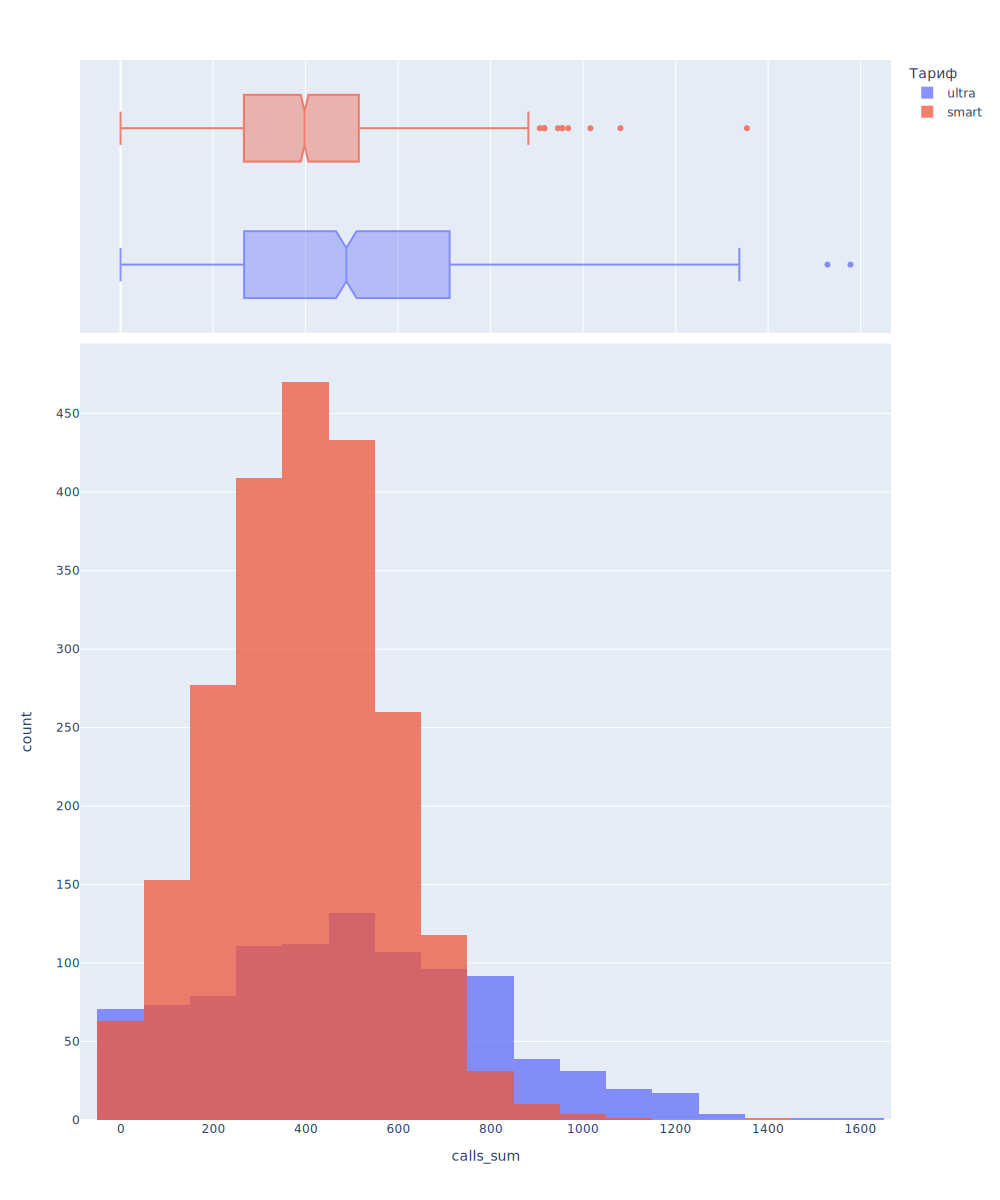

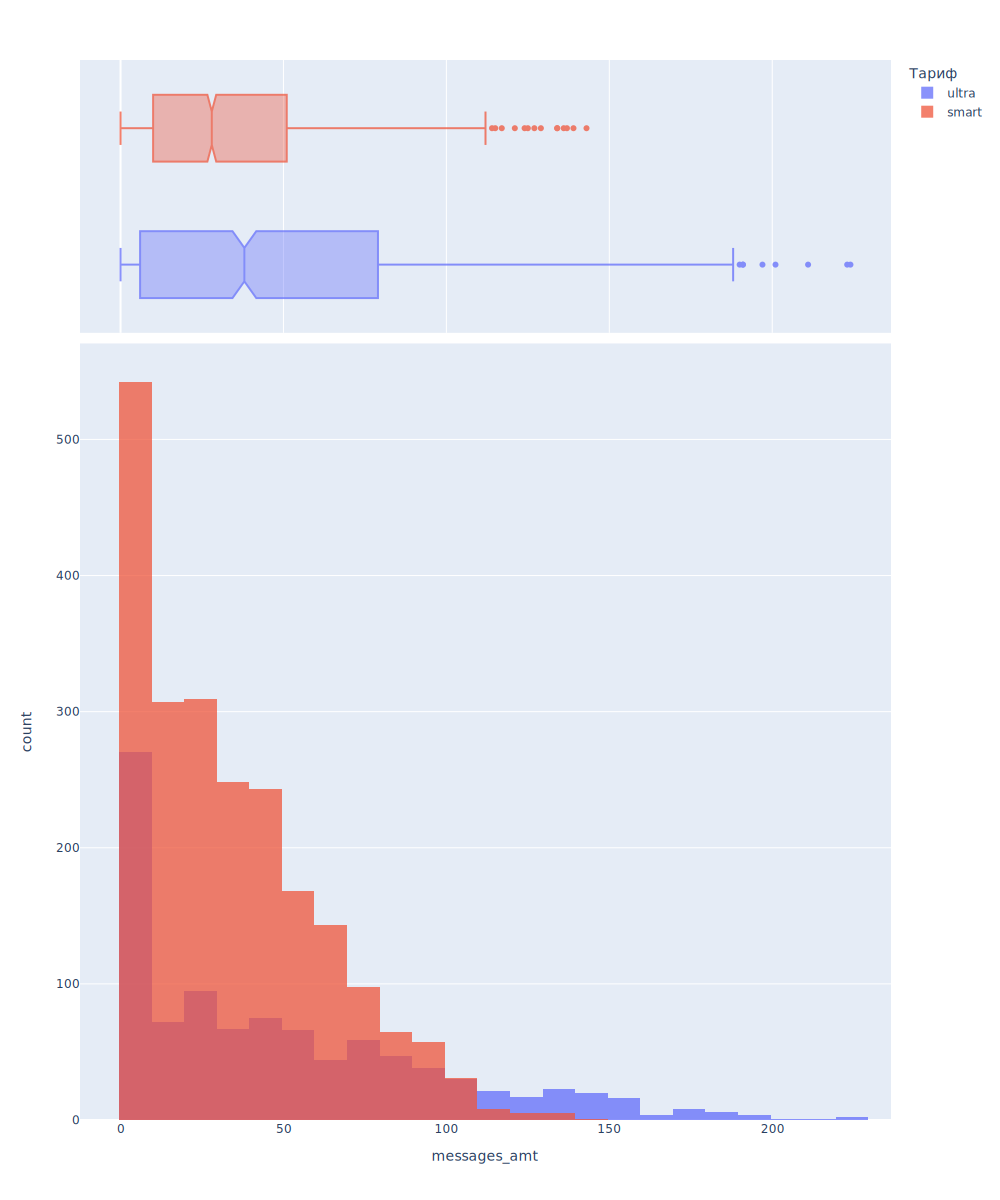

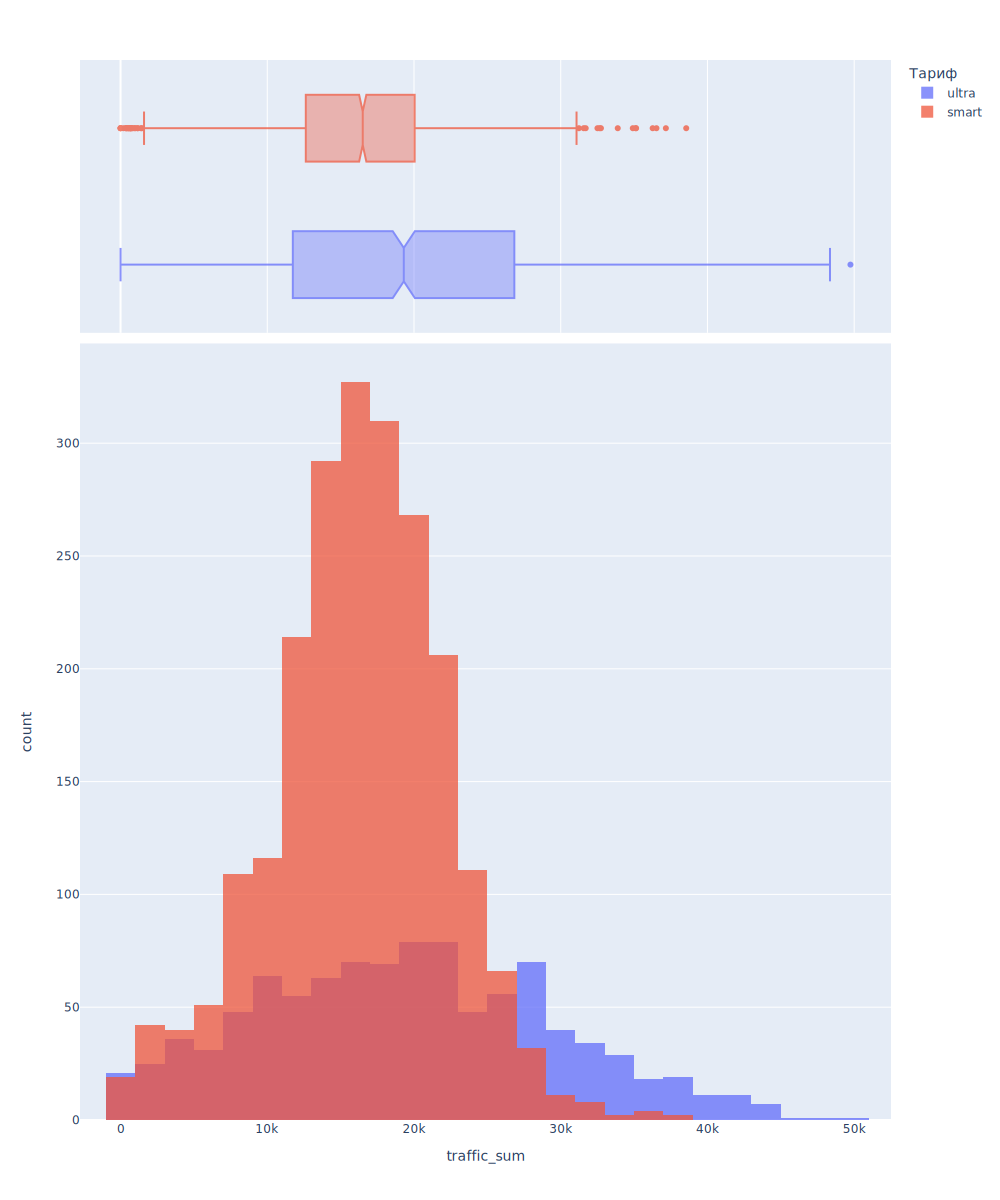

In [15]:
# получение графиков распределения потраченного объёма услуг
cols = [
    'calls_sum',
    'messages_amt',
    'traffic_sum'
    ]
for col in cols:
    fig = px.histogram(
        users,
        x=col,
        nbins=30,
        color='tariff',
        marginal='box',
        width=1000,
        height=1200).update_layout(
            barmode='overlay',
            legend_title='Тариф'
            ).update_traces(opacity=0.75)
    fig.show(renderer='svg')

По графикам можно заметить, что распределения значений потраченных услуг клиентов с тарифом `smart` более симметричные, большая часть показателей сконцентрирована в центральной, средней части графика. Но это за исключением графика с сообщениями, так как много пользователей отправляют небольшое их количество или же не отправляют вовсе. Присутствует не так уж и мало выбросов, в основном в положительную сторону, некоторым из данных клиентов, возможно, стоило бы перейти на расширенный тариф.

Графики пользователей тарифа `ultra` все скошены вправо, выбросов практически нет. Значения распределены более равномерно по всему интервалу значений. Относительно сообщений та же ситуация, большинство пользователей отправляло малое их количество.

Лимиты расширенного тарифа относительно звонков и сообщений выглядят избыточными: 3 000 при максимальном значении 1 578 и 1000 при максимуме 224. Лимиты же базового тарифа можно назвать достаточно оправданными — в целом они больше соответствуют среднему показателю, как и в случае лимитов интернет-трафика.

**Промежуточные итоги**

Рассмотрев распределения потраченных услуг пользователями разных тарифов, можно заключить, что клиентам с планом `ultra` нужен обычно больший объем услуг по сравнению с пользователями тарифа `smart`, который, однако, меньше сконцентрирован вокруг среднего показателя. Также вызывают вопросы некоторые сильно завышенные лимиты в расширенном тарифе.

## Проверка гипотез

Для ответа на итоговый вопрос исследования сформулируем и проверим следующие гипотезы:
- Н0: Средние выручки c пользователей тарифов `ultra` и `smart` равны.
- Н1: Средние выручки c пользователей тарифов `ultra` и `smart` различаются, следовательно, какой-то из них можно назвать более доходным для компании.

Для начала сравним размеры двух разных выборок и подумаем над дисперсиями соответствующих генеральных совокупностей.

In [16]:
# получение размеров и дисперсий выборок с двумя разными тарифами
smart_capacity = len(smart_sample.profit)
ultra_capacity = len(ultra_sample.profit)
smart_var = np.var(smart_sample.profit, ddof=1)
ultra_var = np.var(ultra_sample.profit, ddof=1)

print(f'Размер выборки пользователей тарифа "smart": {smart_capacity}')
print(f'Размер выборки пользователей тарифа "ultra": {ultra_capacity}')
print()
print(f'Дисперсия выручки с пользователей тарифа "smart": {smart_var:.2f}')
print(f'Дисперсия выручки с пользователей тарифа "ultra": {ultra_var:.2f}')

Размер выборки пользователей тарифа "smart": 2230
Размер выборки пользователей тарифа "ultra": 986

Дисперсия выручки с пользователей тарифа "smart": 641402.54
Дисперсия выручки с пользователей тарифа "ultra": 141387.71


Размеры выборок отличаются более, чем в два раза, дисперсии по нескольким параметрам также значительно отличаются, следовательно дисперсии в дальнейшем считать следует по отдельности для каждой выборки, их размеры это позволяют.

Уровень статистической значимости для теста установим в 5%. 

In [17]:
# проверка первой гипотезы
alpha = .05
res = st.ttest_ind(
    smart_sample.profit, 
    ultra_sample.profit,
    equal_var = False
    )

print('P-value:', res.pvalue)
if res.pvalue < alpha:
    print(
        'Средние выручки c пользователей тарифов "ultra" и "smart" различаются'
        )
else:
    print(
        'Средние выручки c пользователей тарифов "ultra" и "smart" практически равны'
        )

P-value: 2.642111711449653e-274
Средние выручки c пользователей тарифов "ultra" и "smart" различаются


Сравним средние значения выборок, чтобы сделать предположения об отношении средних генеральных совокупностей.

In [18]:
# получение отношения средних выручек разных выборок
mean_smart_profit = smart_sample.profit.mean()
mean_ultra_profit = ultra_sample.profit.mean()
print(f'Средняя выручка с пользователей тарифа "smart": {mean_smart_profit:.2f}')
print(f'Средняя выручка с пользователей тарифа "ultra": {mean_ultra_profit:.2f}')
print()
if mean_smart_profit > mean_ultra_profit:
    print(
        'Больше средняя выручка c пользователей тарифов "smart"'
        )
else:
    print(
        'Больше средняя выручка c пользователей тарифов "ultra"'
        )

Средняя выручка с пользователей тарифа "smart": 1257.27
Средняя выручка с пользователей тарифа "ultra": 2070.03

Больше средняя выручка c пользователей тарифов "ultra"


Проведём тест с аналогичными критериями для клиентов оператора из Москвы и остальных пользователей компании. Снова сначала определимся с методом подсчёта дисперсий двух выборок.

Гипотезы будут следующие:
- Н0: Средняя выручка c пользователей из Москвы равна выручке пользователей из других регионов.
- Н1: Средняя выручка c пользователей из Москвы отличается от выручки пользователей из других регионов.

In [19]:
# получение размеров и дисперсий выборок с двумя разными тарифами
moscow_sample = users.query('city=="москва"')
rest_sample = users.query('city!="москва"')
moscow_capacity = len(moscow_sample.profit)
rest_capacity = len(rest_sample.profit)
moscow_var = np.var(moscow_sample.profit, ddof=1)
rest_var = np.var(rest_sample.profit, ddof=1)

print(f'Размер выборки клиентов из Москвы: {moscow_capacity}')
print(f'Размер выборки клиентов из других регионов: {rest_capacity}')
print()
print(f'Дисперсия выручки с клиентов из Москвы: {moscow_var:.2f}')
print(f'Дисперсия выручки с клиентов из других регионов: {rest_var:.2f}')

Размер выборки клиентов из Москвы: 611
Размер выборки клиентов из других регионов: 2605

Дисперсия выручки с клиентов из Москвы: 562832.20
Дисперсия выручки с клиентов из других регионов: 643989.67


Размеры выборок снова сильно различаются, посчитаем дисперсии в тесте также по отдельности.

In [20]:
# проверка второй гипотезы
alpha = .05
res = st.ttest_ind(
    moscow_sample.profit, 
    rest_sample.profit,
    equal_var = False
    )

print('P-value:', res.pvalue)
if res.pvalue < alpha:
    print(
        'Средние выручки c клиентов из Москвы и остальных регионов различаются'
        )
else:
    print(
        'Средние выручки c клиентов из Москвы и остальных регионов практически равны'
        )

P-value: 0.461839146676561
Средние выручки c клиентов из Москвы и остальных регионов практически равны


## Итоговый вывод

В результате исследования на основе обработанных данных представленной выборки можно сделать вывод о том, что больше денег компании приносит тариф "ultra". Нулевую гипотезу о равенстве средних значений выборок с разным тарифом по итогам теста следует отвергнуть, а среднее выборки с расширенным тарифом значительно больше среднего значения выручки с пользователей предложения "smart". Между средним доходом с клинтов из Москвы и с пользователей из других регионов разницы не выявлено.

Если полученный вывод действительно верен и в масштабе всех пользователей компании, то коммерческому департаменту в зависимости от цели ("подтянуть" отстающие показатели и сбалансировать предложения, либо сконцентрироваться на более прибыльном продукте) можно порекомендовать распределить большую часть рекламного бюджета или на тариф "smart", или на тариф "ultra" соответственно.
В случае сомнений относительно правильности полученных результатов можно задуматься об анализе и проведении тестов на основе либо большей выборки, либо генеральной совокупности данных о клиентах в зависимости от затрат на реализацию соответствующего решения и важности получения точного ответа на поставленный в исследовании вопрос.

Также стоит обратить внимание на, возможно, слишком завышенные лимиты минут и сообщений расширенного тарифа.